In [1]:
import pandas as pd
import datetime
import requests
import json
import sys, os
import itertools
import time
import numpy as np
from os import path
from pathlib import Path
from binance.spot import Spot
from twelvedata import TDClient
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import itertools
import xgboost as xgb
import seaborn as sns
from typing import Union, Dict, List
import talib
import ta
import shap
sys.path.insert(0, os.path.join(os.getcwd(), ".."))
import fin_utilities 
cfg = fin_utilities.__cfg_reading("pred")
import my_functions
from coinmetrics.api_client import CoinMetricsClient
import matplotlib as mpl
# Set the default color cycle
mpl.rcParams.update(mpl.rcParamsDefault)


#td = TDClient(apikey=cfg['TWELVEDATA']['API'])  

PROJECT_DIR = eval(cfg['PROJECT_PATH'])
DATA_PATH   = PROJECT_DIR / cfg['DATA_FOLDER']
SOURCE      = cfg['API_DATA_SOURCE']
URL         = cfg[SOURCE]['API_URL_HIST_DATA']
COLUMNS     = cfg[SOURCE]['COLUMN_NAMES']
PARAMS      = cfg[SOURCE]['REQ_PARAMS']
PAIR        = cfg['SYMBOL'] + cfg['STABLECOIN']
MAX_LENGTH  = cfg['MAX_TRADE_DURATION']
XGB_PARAM   = cfg['xgb']


c:\Users\ma.orlandi\Anaconda3\envs\obb\lib\site-packages\torch\onnx\_internal\_beartype.py:30: UserWarning: module 'beartype.roar' has no attribute 'BeartypeDecorHintPep585DeprecationWarning'
  warnings.warn(f"{e}")


In [43]:
client = CoinMetricsClient()
print(client)

In [ ]:
# Gets list of blocks for Ethereum
import requests
response = requests.get('https://api.coinmetrics.io/v4/blockchain/eth/blocks?pretty=true&api_key=<your_key>').json()
print(response)


In [40]:
frequency  = "1d"
start_time = "2009-01-01"
end_time   = "2023-02-05"
asset      = ["btc"]
metrics_a = [
    'CapAct1yrUSD',
    'CapMVRVCur',
    'CapMVRVFF',
    'CapMrktCurUSD',
    'CapMrktEstUSD',
    'CapMrktFFUSD',
    'CapRealUSD',
    'AdrActCnt',
    'FeeTotUSD',
    'FeeMeanUSD',
    'DiffLast',
    'DiffMean',
    'FlowInExNtv',
    'FlowInExUSD',
    'FlowOutExNtv',
    'FlowOutExUSD',
    'HashRate',		
    'HashRate30d',
    'NDF',
    'FlowTfrFromExCnt',
    'SplyAdrTop1Pct',
    'SplyMiner0HopAllNtv',
    'SplyMiner0HopAllUSD',
    'SplyMiner1HopAllNtv',
    'SplyMiner1HopAllUSD',
    'TxCnt',
    'TxCntSec',
    'TxTfrCnt'

]

df_mcap = client.get_asset_metrics(
                                    assets    = asset,
                                    metrics   = metrics_a,
                                    frequency = frequency,
                                    start_time= start_time,
                                    end_time  = end_time,
                                    page_size = 10000
                                ).to_dataframe()
df_mcap

,asset,time,AdrActCnt,CapAct1yrUSD,CapMVRVCur,CapMVRVFF,CapMrktCurUSD,CapMrktEstUSD,CapMrktFFUSD,CapRealUSD,...,NDF,SplyAdrTop1Pct,SplyMiner0HopAllNtv,SplyMiner0HopAllUSD,SplyMiner1HopAllNtv,SplyMiner1HopAllUSD,TxCnt,TxCntSec,TxTfrCnt,principal_market_usd
0,btc,2009-01-03 00:00:00+00:00,0,None,None,None,None,None,None,0.0,...,None,0.0,50.0,None,50.0,None,0,0.0,0,None
1,btc,2009-01-04 00:00:00+00:00,0,None,None,None,None,None,None,0.0,...,None,0.0,50.0,None,50.0,None,0,0.0,0,None
2,btc,2009-01-05 00:00:00+00:00,0,None,None,None,None,None,None,0.0,...,None,0.0,50.0,None,50.0,None,0,0.0,0,None
3,btc,2009-01-06 00:00:00+00:00,0,None,None,None,None,None,None,0.0,...,None,0.0,50.0,None,50.0,None,0,0.0,0,None
4,btc,2009-01-07 00:00:00+00:00,0,None,None,None,None,None,None,0.0,...,None,0.0,50.0,None,50.0,None,0,0.0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142,btc,2023-02-01 00:00:00+00:00,1050528,154362621309.09605668301901291,1.196241930423,0.861856310148,457433839815.109798416131050605,457416998038.184547636,329567315183.87374300259239134,382392414261.365601,...,0.324220509097,17222345.408067,1802209.959014,42761400838.86060164748121959,2569467.039857,60966265048.085369855592982425,343824,3.979444,890851,coinbase-btc-usd-spot
5143,btc,2023-02-02 00:00:00+00:00,983946,150681969171.599475637387303482,1.184795889398,0.853464431963,453182984739.087481763485849248,453165872083.4987139552,326449105796.707377751492843464,382498782106.23114,...,0.324875975436,17224781.683983,1802354.462974,42365431793.807945874152148894,2569508.272379,60397846091.549632709016937348,335421,3.882188,896148,coinbase-btc-usd-spot
5144,btc,2023-02-03 00:00:00+00:00,988867,150273538776.28805361363899712,1.181415746292,0.850970452062,452049702984.097911637682895936,452034246444.1374432096,325610134544.146004676584546904,382633890231.091309,...,0.32484282418,17227325.37683,1802284.825939,42256033321.403012147998084512,2571375.745117,60287995328.8577275377513018,317695,3.677025,899457,coinbase-btc-usd-spot
5145,btc,2023-02-04 00:00:00+00:00,961115,149647997797.290925613539563122,1.176437733184,0.847222179515,450328730991.77458087072933871,450312026811.61260685,324308272514.133222982192813364,382790111443.578796,...,0.324793322221,17227598.683621,1802173.77459,42090713540.83929822970677152,2561980.941209,59836408349.696828149365440298,302062,3.496088,828676,coinbase-btc-usd-spot


In [41]:
#droppo tutte le colonne "status" inutili
df_mcap.drop(columns=[col for col in df_mcap.columns if 'status' in col], inplace=True)
df_mcap = my_functions.round_float_cols(df_mcap)
df_mcap.tail(5)

,asset,time,AdrActCnt,CapAct1yrUSD,CapMVRVCur,CapMVRVFF,CapMrktCurUSD,CapMrktEstUSD,CapMrktFFUSD,CapRealUSD,...,NDF,SplyAdrTop1Pct,SplyMiner0HopAllNtv,SplyMiner0HopAllUSD,SplyMiner1HopAllNtv,SplyMiner1HopAllUSD,TxCnt,TxCntSec,TxTfrCnt,principal_market_usd
5142,btc,2023-02-01 00:00:00+00:00,1050528,154362621309.09605668301901291,1.196241930423,0.861856310148,457433839815.109798416131050605,457416998038.184547636,329567315183.87374300259239134,382392414261.365601,...,0.324220509097,17222345.408067,1802209.959014,42761400838.86060164748121959,2569467.039857,60966265048.085369855592982425,343824,3.979444,890851,coinbase-btc-usd-spot
5143,btc,2023-02-02 00:00:00+00:00,983946,150681969171.599475637387303482,1.184795889398,0.853464431963,453182984739.087481763485849248,453165872083.4987139552,326449105796.707377751492843464,382498782106.23114,...,0.324875975436,17224781.683983,1802354.462974,42365431793.807945874152148894,2569508.272379,60397846091.549632709016937348,335421,3.882188,896148,coinbase-btc-usd-spot
5144,btc,2023-02-03 00:00:00+00:00,988867,150273538776.28805361363899712,1.181415746292,0.850970452062,452049702984.097911637682895936,452034246444.1374432096,325610134544.146004676584546904,382633890231.091309,...,0.32484282418,17227325.37683,1802284.825939,42256033321.403012147998084512,2571375.745117,60287995328.8577275377513018,317695,3.677025,899457,coinbase-btc-usd-spot
5145,btc,2023-02-04 00:00:00+00:00,961115,149647997797.290925613539563122,1.176437733184,0.847222179515,450328730991.77458087072933871,450312026811.61260685,324308272514.133222982192813364,382790111443.578796,...,0.324793322221,17227598.683621,1802173.77459,42090713540.83929822970677152,2561980.941209,59836408349.696828149365440298,302062,3.496088,828676,coinbase-btc-usd-spot
5146,btc,2023-02-05 00:00:00+00:00,802171,147091395542.707514032420362112,1.156408398602,0.832585539837,442670747793.245437917661992521,442652882651.0919327203,318712025930.511253762598594376,382797935684.581665,...,0.324612734351,17229501.979274,1802264.384316,41374989323.625086858118650608,2563519.070471,58851284581.032878897882589789,256347,2.966979,709343,binance.us-btc-usd-spot


In [31]:
df_mcap = df_mcap[df_mcap['AdrActCnt']!=0]

In [32]:
# EXPORT DI TUTTI I DATI DA TUTTI GLI EXCHANGE
from typing import Optional
import logging

logger = logging.getLogger()
stream_handler = logging.StreamHandler()
level = logging.getLevelName("INFO")
stream_handler.level = level
formatter = logging.Formatter(
    datefmt="[%Y-%m-%d %H:%M:%S]", fmt="%(asctime)-15s %(levelname)s %(message)s"
)
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
logger.level = level

# use it if you want to get specific exchanges or leave it empty if you want to get all exchanges data
EXCHANGES_TO_EXPORT = {}

# use it if you want to get specific markets or leave it empty if you want to get all markets
# example of market name to be used in this filter: "binance-BTCUSDT-future",
# note that if you specified exchanges filter, it will act as selecting intersection with the markets to export
# not as union.
MARKETS_TO_EXPORT = {}

# example values: "spot", "future", "option"
# you can use all 3 if you want or just a subset
MARKET_TYPES_TO_COLLECT = {
    "spot"   
}

# leave it empty to catch all
BASE_MARKETS = {
    "btc",
}

# leave it empty to catch all
QUOTE_MARKETS = {
    "usdt",
}

# 1m, 5m, 10m, 15m, 30m, 1h, 4h, 1d
FREQUENCY = "1d"

DST_ROOT = "./data"
EXPORT_START_DATE = "2009-01-01"
EXPORT_END_DATE: Optional[str] = None
# path to local file that is used to not reexport data if it was already exported
PROCESSED_DAYS_REGISTRY_FILE_PATH = "candles_processed_days_registry.txt"

client = CoinMetricsClient()

if __name__ == "__main__":
    export_start_time = datetime.datetime.now()
    try:
        my_functions.export_data(
                client,
                PROCESSED_DAYS_REGISTRY_FILE_PATH, 
                EXCHANGES_TO_EXPORT,
                MARKETS_TO_EXPORT,
                MARKET_TYPES_TO_COLLECT,
                BASE_MARKETS,
                QUOTE_MARKETS,
                EXPORT_START_DATE,
                str(datetime.datetime.now().date()), 
                DST_ROOT, 
                FREQUENCY 
        )
    finally:
        print("export took: %s", datetime.datetime.now() - export_start_time)

getting markets: %s ['bibox-btc-usdt-spot', 'binance-btc-usdt-spot', 'binance.us-btc-usdt-spot', 'bitfinex-btc-usdt-spot', 'bitstamp-btc-usdt-spot', 'bittrex-btc-usdt-spot', 'bybit-btc-usdt-spot', 'cex.io-btc-usdt-spot', 'coinbase-btc-usdt-spot', 'crypto.com-btc-usdt-spot', 'gate.io-btc-usdt-spot', 'gemini-btc-usdt-spot', 'hitbtc-btc-usdt-spot', 'huobi-btc-usdt-spot', 'kraken-btc-usdt-spot', 'kucoin-btc-usdt-spot', 'lbank-btc-usdt-spot', 'liquid-btc-usdt-spot', 'localbitcoins-btc-usdt-spot', 'mexc-btc-usdt-spot', 'okex-btc-usdt-spot', 'poloniex-btc-usdt-spot', 'therocktrading-btc-usdt-spot', 'upbit-btc-usdt-spot', 'zb.com-btc-usdt-spot']
export took: %s 0:00:01.717003


In [33]:
mkts = my_functions.get_markets_to_process(client,EXCHANGES_TO_EXPORT, MARKETS_TO_EXPORT, MARKET_TYPES_TO_COLLECT, BASE_MARKETS, QUOTE_MARKETS)

df = pd.DataFrame()

for mkt in mkts:
    print(mkt) 
    
    market_data_root = "/".join(                                                                                                                                    
                (                                                                                                                                                        
                    DST_ROOT.rstrip("/"),                                                                                                                                
                    mkt["market"].split("-")[0],                                                                                                                         
                    my_functions.get_instrument_root(mkt),                                                                                                                            
                ) 
    )      
    print(f'manng {my_functions.get_instrument_root(mkt)}')

    df = pd.concat([df,
                    my_functions.read_data_for_a_market(
                                market_data_root,                                                                                                                                                               
                                FREQUENCY                                         
                            )
                    ],
                     ignore_index=True)       

df = df[df['volume'] == df.groupby('time')['volume'].transform('max')].sort_values(by='time').reset_index(drop=True)
df['time'] = pd.to_datetime(df['time'])

{'market': 'bibox-btc-usdt-spot', 'min_time': '2023-02-16T15:57:03.000000000Z', 'max_time': '2023-02-17T15:30:20.236000000Z', 'exchange': 'bibox', 'type': 'spot', 'trades': {'min_time': '2023-02-16T15:57:03.000000000Z', 'max_time': '2023-02-17T15:30:20.236000000Z'}, 'base': 'btc', 'quote': 'usdt', 'symbol': 'BTC_USDT'}
manng btc_usdt_spot
reading data from:  ./data/bibox/btc_usdt_spot/candles1d.csv
{'market': 'binance-btc-usdt-spot', 'min_time': '2023-02-16T15:57:03.000000000Z', 'max_time': '2023-02-17T15:30:19.951000000Z', 'exchange': 'binance', 'type': 'spot', 'trades': {'min_time': '2023-02-16T15:57:03.000000000Z', 'max_time': '2023-02-17T15:30:19.951000000Z'}, 'orderbooks': {'min_time': '2023-02-16T15:57:03.000000000Z', 'max_time': '2023-02-17T15:30:10.000000000Z'}, 'quotes': {'min_time': '2023-02-16T15:57:03.000000000Z', 'max_time': '2023-02-17T15:30:10.000000000Z'}, 'base': 'btc', 'quote': 'usdt', 'symbol': 'BTCUSDT'}
manng btc_usdt_spot
reading data from:  ./data/binance/btc_usd

In [34]:
df['time'] = pd.to_datetime(df['time'])
df_mcap['time'] = pd.to_datetime(df_mcap['time'])
df_btc = pd.merge(df_mcap,df, on='time', how='left')
df_btc.drop(columns=['asset','market'], inplace=True)
df_btc = df_btc[df_btc['AdrActCnt']>0]
df_btc['time'] = pd.to_datetime(df_mcap['time']).dt.date
df_btc = my_functions.round_float_cols(df_btc)
df_btc


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,time,AdrActCnt,CapAct1yrUSD,CapMVRVCur,CapMVRVFF,CapMrktCurUSD,CapMrktEstUSD,CapMrktFFUSD,CapRealUSD,DiffLast,...,TxCntSec,TxTfrCnt,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count
0,NaN,19,None,None,None,None,None,None,0.0,1,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,61,None,None,None,None,None,None,0.0,1,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,95,None,None,None,None,None,None,0.0,1,...,0.000012,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,101,None,None,None,None,None,None,0.0,1,...,0.000069,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,123,None,None,None,None,None,None,0.0,1,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5136,2023-01-26,1050528,154362621309.09605668301901291,1.196241930423,0.861856310148,457433839815.109798416131050605,457416998038.184547636,329567315183.87374300259239134,382392414261.365601,39350942467772.63,...,3.979444,890851,23125.13,23732.66,23812.66,22760.23,23207.09,310790.42,7.212354e+09,7863213.0
5137,2023-01-27,983946,150681969171.599475637387303482,1.184795889398,0.853464431963,453182984739.087481763485849248,453165872083.4987139552,326449105796.707377751492843464,382498782106.23114,39350942467772.63,...,3.882188,896148,23731.41,23488.94,24255.00,23363.27,23817.24,364177.21,8.676163e+09,9102300.0
5138,2023-01-28,988867,150273538776.28805361363899712,1.181415746292,0.850970452062,452049702984.097911637682895936,452034246444.1374432096,325610134544.146004676584546904,382633890231.091309,39350942467772.63,...,3.677025,899457,23489.33,23431.90,23715.70,23204.62,23473.15,332571.03,7.808111e+09,8007846.0
5139,2023-01-29,961115,149647997797.290925613539563122,1.176437733184,0.847222179515,450328730991.77458087072933871,450312026811.61260685,324308272514.133222982192813364,382790111443.578796,39350942467772.63,...,3.496088,828676,23431.90,23326.84,23587.78,23253.96,23396.50,166126.47,3.887452e+09,4852404.0


In [35]:
df_btc = df_btc.replace('None', None)
df_btc[df_btc.columns[1:]] = df_btc[df_btc.columns[1:]].apply(pd.to_numeric)

In [36]:
df_btc = my_functions.round_float_cols(df_btc,4)
df_btc

,time,AdrActCnt,CapAct1yrUSD,CapMVRVCur,CapMVRVFF,CapMrktCurUSD,CapMrktEstUSD,CapMrktFFUSD,CapRealUSD,DiffLast,...,TxCntSec,TxTfrCnt,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count
0,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.000000e+00,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,61,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.000000e+00,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,95,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.000000e+00,...,0.000012,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,101,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.000000e+00,...,0.000069,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,123,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.000000e+00,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5136,2023-01-26,1050528,1.543626e+11,1.1962,0.8619,4.574338e+11,4.574170e+11,3.295673e+11,382392414261.365601,3.935094e+13,...,3.979444,890851,23125.13,23732.66,23812.66,22760.23,23207.09,310790.42,7.212354e+09,7863213.0
5137,2023-01-27,983946,1.506820e+11,1.1848,0.8535,4.531830e+11,4.531659e+11,3.264491e+11,382498782106.23114,3.935094e+13,...,3.882188,896148,23731.41,23488.94,24255.00,23363.27,23817.24,364177.21,8.676163e+09,9102300.0
5138,2023-01-28,988867,1.502735e+11,1.1814,0.8510,4.520497e+11,4.520342e+11,3.256101e+11,382633890231.091309,3.935094e+13,...,3.677025,899457,23489.33,23431.90,23715.70,23204.62,23473.15,332571.03,7.808111e+09,8007846.0
5139,2023-01-29,961115,1.496480e+11,1.1764,0.8472,4.503287e+11,4.503120e+11,3.243083e+11,382790111443.578796,3.935094e+13,...,3.496088,828676,23431.90,23326.84,23587.78,23253.96,23396.50,166126.47,3.887452e+09,4852404.0


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


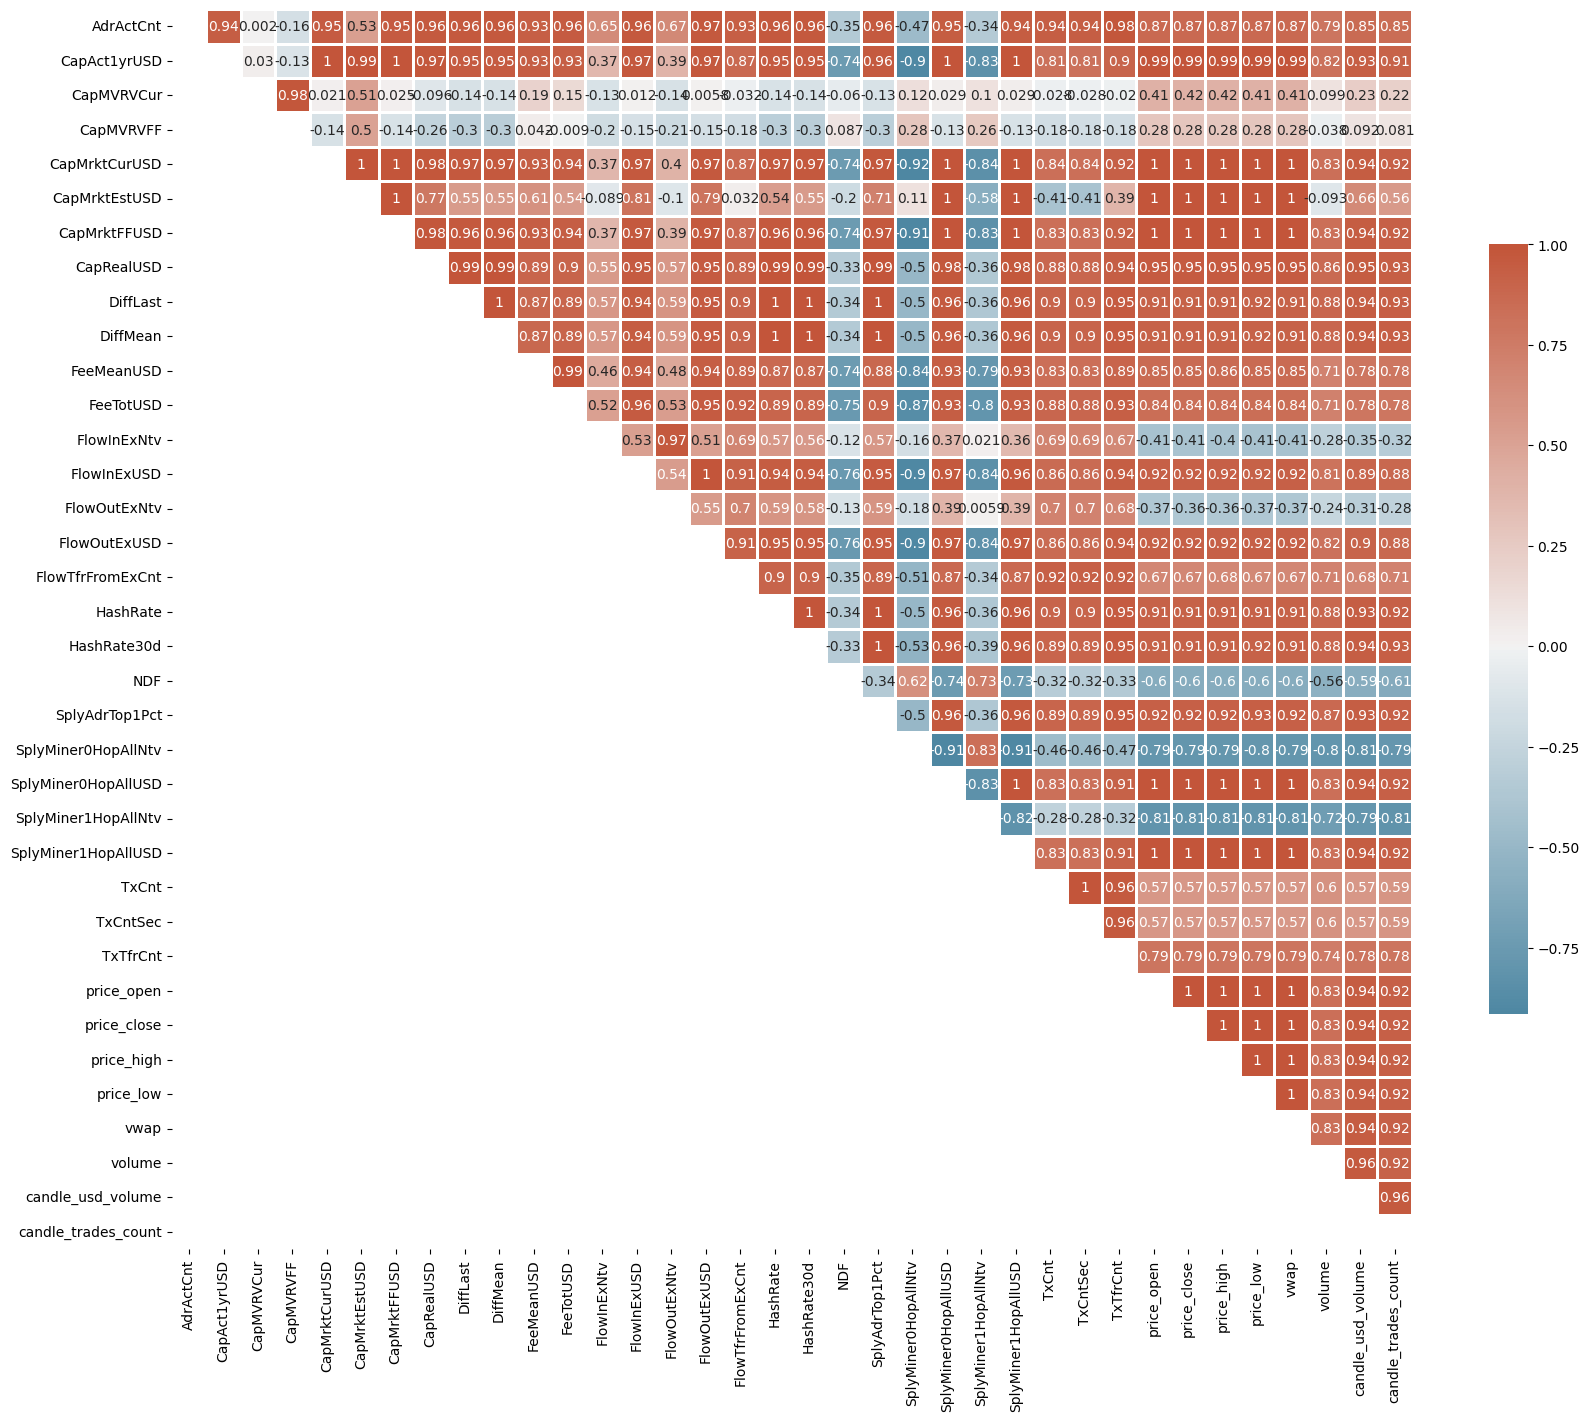

In [37]:
my_functions.plt_correlation(df_btc)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


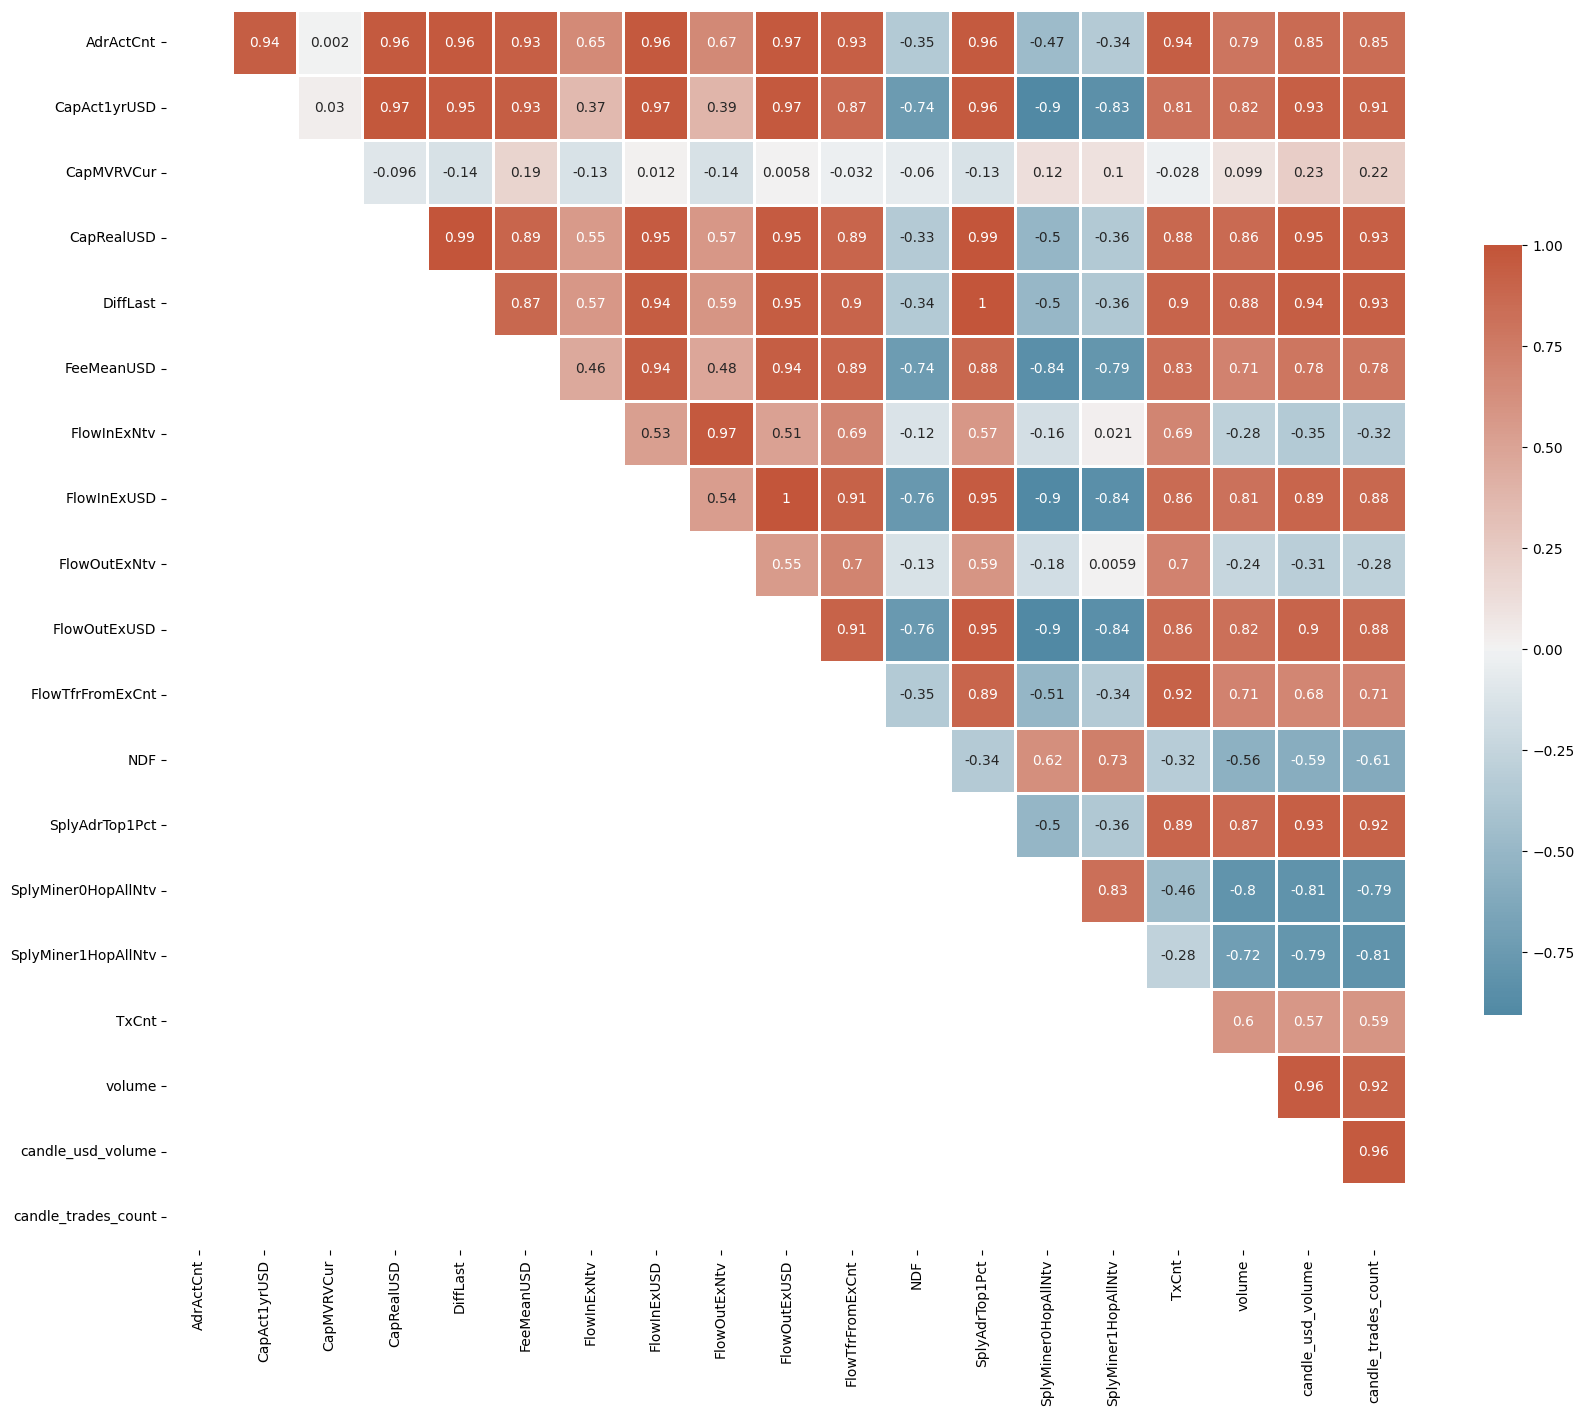

In [38]:
# Create correlation matrix
corr_matrix = df_btc.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df_btc_clean = df_btc.drop(to_drop, axis=1)

my_functions.plt_correlation(df_btc_clean)

Removing Correlated Features
Removed Columns {'price_low', 'TxCntSec', 'TxTfrCnt', 'price_close', 'CapMrktCurUSD', 'CapMrktEstUSD', 'HashRate30d', 'SplyMiner1HopAllUSD', 'HashRate', 'price_high', 'vwap', 'FeeTotUSD', 'price_open', 'DiffMean', 'CapMrktFFUSD', 'SplyMiner0HopAllUSD', 'CapMVRVFF'}


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


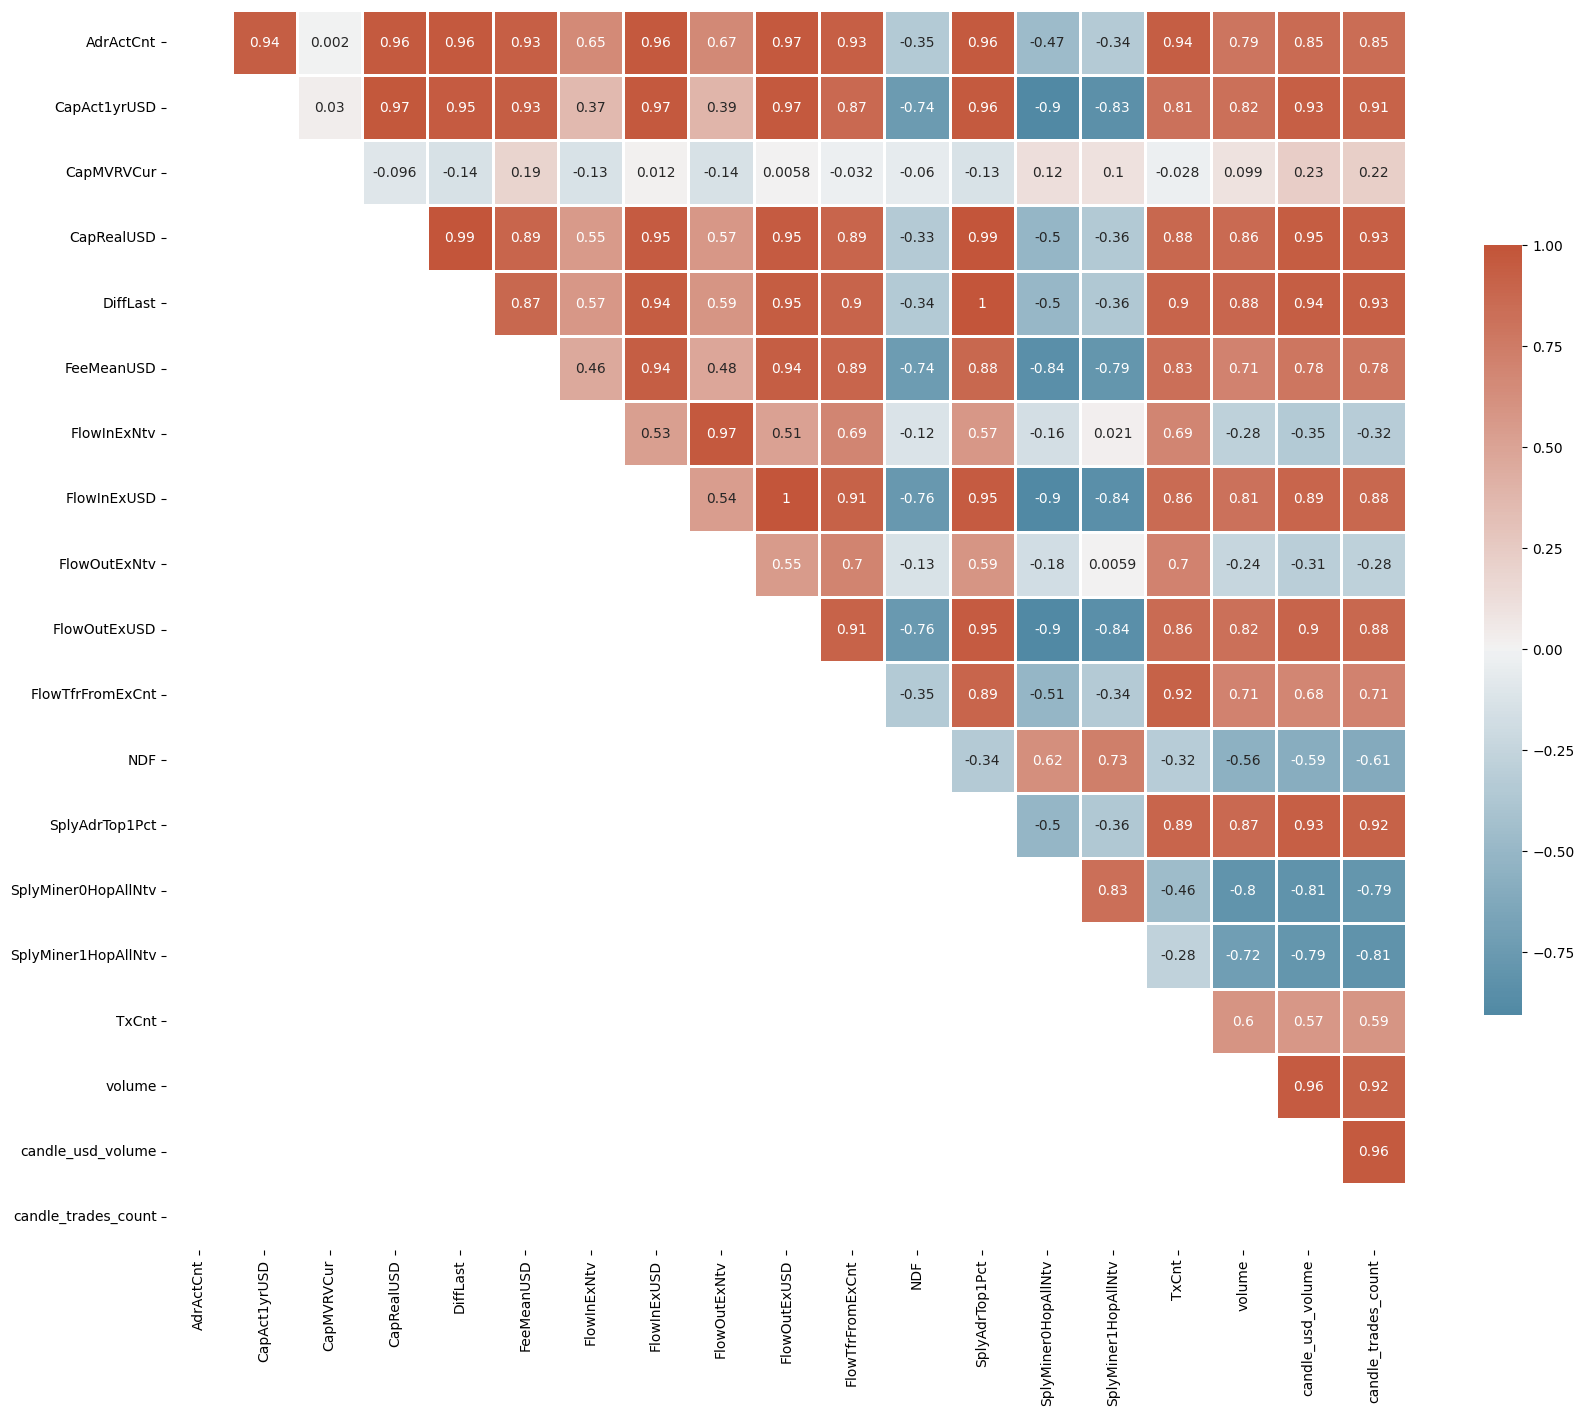

In [39]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x


print("Removing Correlated Features")
# Pass DataFrame and Threshold value 
my_functions.plt_correlation(remove_collinear_features(df_btc,0.95))

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]


my_functions.plt_correlation(calculate_vif_(df_btc))

invalid value encountered in reduce


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''